In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt

from src.helix import helix_labels, helix_observations, ToyVAE

In [2]:
# Dataset Hyperparameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_training_samples = 1024
nhelix = 2
gen = torch.Generator().manual_seed(67280421310721)
torch.manual_seed(67280421310721)

In [3]:
Y = helix_labels(num_training_samples, strands=nhelix, gen=gen).to(device)
X = helix_observations(Y, w=1., Rx=1., Ry=1., Rz=1.)
Y.shape, X.shape

(torch.Size([1024, 2]), torch.Size([1024, 3]))

In [4]:
# plt.figure()
# data_ax = plt.axes(projection='3d')
# plt.plot(*X.cpu().t(), ls='', marker='.', c='k', ms=1, );

In [5]:
# Model Hyperparameters

budget = 5000
batch_size = 128

latent_dim = 2


beta = 0.05
hidden_dims = [32, 32, 32, 32]
nonlin = nn.ELU

optim_type = opt.Adam
lr = 0.01

In [6]:
torch.manual_seed(gen.initial_seed())
model = ToyVAE(obs_dim=X.size(1), latent_dim=2, beta=beta, hidden=hidden_dims, nonlin=nonlin)
model.to(device)
optimizer = optim_type(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, amsgrad=True,)
print(model)

ToyVAE(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
  (criterion): MSELoss()
)


In [7]:
dataloader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
loader = iter([])
losses = []

In [8]:
model.train()
itr = tqdm(range(budget))
if len(losses):
    itr.set_description(f'{losses[-1]:.3f}')
for i in itr:
    try:
        batch = next(loader)
    except StopIteration:
        loader = iter(dataloader)
        batch = next(loader)
    
    x, = batch
    x = x.to(device)
    loss, info = model(x)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(info['rec_loss'].mean().item())
    itr.set_description(f'Loss: {np.mean(losses[-100:]):.3f}')
# plt.figure()
# plt.plot(losses);

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
model.eval()
with torch.no_grad():
    Z = model.encode(X)
    S = Z.mean
    rec = model.decode(S)

<IPython.core.display.Javascript object>


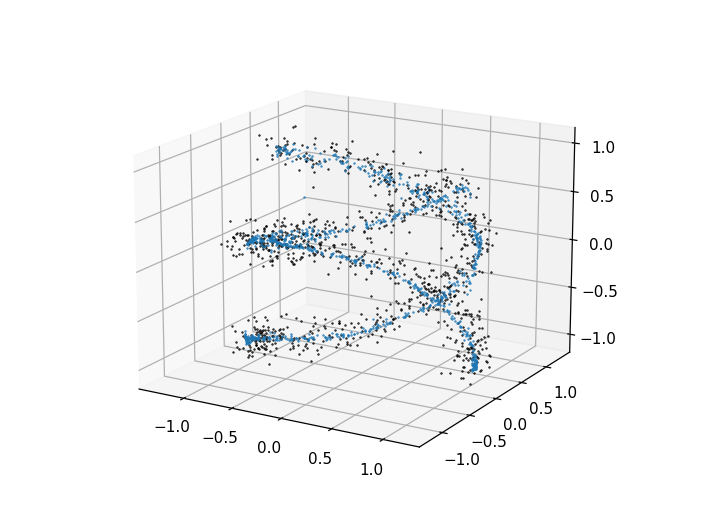

In [16]:
plt.figure()
plt.axes(projection='3d')
plt.plot(*X.cpu().t(), ls='', marker='.', c='k', ms=1, );
plt.plot(*rec.cpu().t(), ls='', marker='.', c='C0', ms=1, );

In [12]:
from src.maps import response_map_2d, compute_divergence_2d, compute_mean_curvature_2d, plot_map, plot_posterior_2d, collect_posterior_means

In [13]:
with torch.no_grad():
    Z = collect_posterior_means(model, X, pbar=tqdm, batch_size=1024)
Z.shape

  0%|          | 0/1024 [00:00<?, ?it/s]

torch.Size([1024, 2])

In [14]:
r = 2
n = 150
extent = [-r, r, -r, r]
umap = response_map_2d(model, 0, 1, n=n, extent=extent, batch_size=1024, device=device, pbar=tqdm)
mmap = umap.norm(p=2,dim=-1)
dmap = compute_divergence_2d(umap)
cmap = compute_mean_curvature_2d(umap)

/is/ei/fleeb/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/22500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


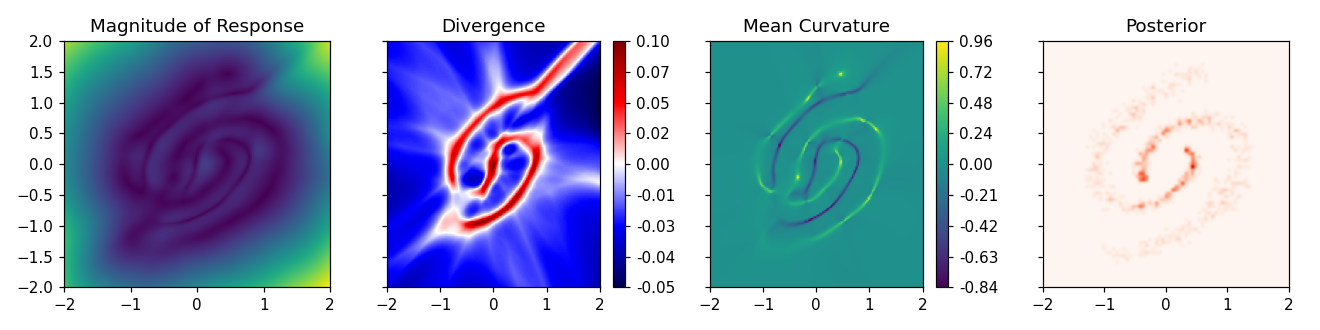

In [15]:
im_kwargs = dict(aspect = 'auto', extent=extent)
fg, axs = plt.subplots(1,4, figsize=(12,3),sharex=True, sharey=True)
plot_map(mmap, fgax=(fg,axs[0]), rescale=False, colorbar=False, **im_kwargs);
plt.title('Magnitude of Response')
plot_map(dmap, fgax=(fg,axs[1]), cmap='seismic', colorbar=True, **im_kwargs);
plt.title('Divergence')
plot_map(cmap, fgax=(fg,axs[2]), cmap='viridis', colorbar=True, **im_kwargs);
plt.title('Mean Curvature')
plot_posterior_2d(S, 0, 1, fgax=(fg,axs[3]), bins=n//2, extent=extent)
plt.title('Posterior')
plt.tight_layout();